# PaSST Model Testing on Real-World Audio

This notebook tests the trained PaSST transformer model (trained on OpenMIC + Synthetic data) on real-world audio examples to evaluate its performance on unseen data.


In [1]:
!pip -q install torchcodec hear21passt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.2 MB/s eta 0:00:00


In [2]:
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd

print("torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


torch: 2.9.0+cu126
torchaudio: 2.9.0+cu126
cuda available: True
gpu: NVIDIA L4


In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


## 1. Define Instrument Tags and Load Model


In [4]:
TAGS = [
    "accordion","banjo","bass","cello","clarinet","cymbals","drums","flute","guitar","mallet_percussion",
    "mandolin","organ","piano","saxophone","synthesizer","trombone","trumpet","ukulele","violin","voice"
]

print(f"Number of instrument classes: {len(TAGS)}")
print("Classes:", ", ".join(TAGS))


Number of instrument classes: 20
Classes: accordion, banjo, bass, cello, clarinet, cymbals, drums, flute, guitar, mallet_percussion, mandolin, organ, piano, saxophone, synthesizer, trombone, trumpet, ukulele, violin, voice


In [5]:
from hear21passt.base import get_basic_model, get_model_passt

# Load model architecture (same as training)
model = get_basic_model(mode="logits")
model.net = get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=len(TAGS))
model = model.to(DEVICE)

# Load trained weights
BEST_PATH = Path("/content/drive/MyDrive/model_weights/finetuning/passt_openmic_plus_synth_best.pth")
assert BEST_PATH.exists(), f"Model weights not found at {BEST_PATH}"

model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))
model.eval()

print("Model loaded successfully!")
print(f"Model weights: {BEST_PATH}")




 Loading PASST TRAINED ON AUDISET 




100%|██████████| 329M/329M [00:07<00:00, 43.1MB/s]


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

## 2. Audio Preprocessing Function


In [6]:
TARGET_SR = 32000
CLIP_SECONDS = 10
TARGET_LEN = TARGET_SR * CLIP_SECONDS

def preprocess_audio(audio_path):
    """
    Preprocess audio file to match training pipeline:
    - Load audio
    - Convert to mono
    - Resample to 32kHz
    - Pad/trim to 10 seconds
    """
    wav, sr = torchaudio.load(audio_path)  # [C, T]

    # Convert to mono if stereo
    if wav.ndim == 2 and wav.size(0) > 1:
        wav = wav.mean(dim=0, keepdim=True)  # mono [1, T]

    # Resample to target sample rate
    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)

    # Crop/pad to 10 seconds
    T = wav.size(1)
    if T < TARGET_LEN:
        pad = TARGET_LEN - T
        wav = torch.nn.functional.pad(wav, (0, pad))
    elif T > TARGET_LEN:
        wav = wav[:, :TARGET_LEN]

    return wav.squeeze(0)  # [T]

print("Preprocessing function defined!")
print(f"Target sample rate: {TARGET_SR} Hz")
print(f"Target duration: {CLIP_SECONDS} seconds")
print(f"Target length: {TARGET_LEN} samples")


Preprocessing function defined!
Target sample rate: 32000 Hz
Target duration: 10 seconds
Target length: 320000 samples


## 3. Load and Preprocess Test Audio


In [29]:
AUDIO_PATH= Path("/content/saxophone_piano.wav")

# If not found, allow manual upload
if AUDIO_PATH is None:
    print("Audio file not found in common locations.")
    print("Option 1: Upload the file to Colab using the cell below")
    print("Option 2: Upload to Google Drive at /content/drive/MyDrive/deep_learning/")
    print("\nTo upload directly to Colab, uncomment and run:")
    print("from google.colab import files")
    print("uploaded = files.upload()")
    print("AUDIO_PATH = Path(list(uploaded.keys())[0])")
else:
    print(f"Loading audio from: {AUDIO_PATH}")

    # Load and preprocess
    wav_processed = preprocess_audio(str(AUDIO_PATH))

    # Get original audio info
    wav_orig, sr_orig = torchaudio.load(str(AUDIO_PATH))
    print(f"\nOriginal audio info:")
    print(f"  File: {AUDIO_PATH.name}")
    print(f"  Sample rate: {sr_orig} Hz")
    print(f"  Channels: {wav_orig.size(0)}")
    print(f"  Duration: {wav_orig.size(1) / sr_orig:.2f} seconds")
    print(f"  Shape: {wav_orig.shape}")

    print(f"\nProcessed audio info:")
    print(f"  Sample rate: {TARGET_SR} Hz")
    print(f"  Duration: {len(wav_processed) / TARGET_SR:.2f} seconds")
    print(f"  Shape: {wav_processed.shape}")

    # Play audio
    print("\nPlaying audio:")
    ipd.display(ipd.Audio(wav_processed.numpy(), rate=TARGET_SR))


Loading audio from: /content/saxophone_piano.wav

Original audio info:
  File: saxophone_piano.wav
  Sample rate: 48000 Hz
  Channels: 2
  Duration: 10.00 seconds
  Shape: torch.Size([2, 480000])

Processed audio info:
  Sample rate: 32000 Hz
  Duration: 10.00 seconds
  Shape: torch.Size([320000])

Playing audio:


## 4. Run Inference


In [30]:
# Prepare input tensor
wav_tensor = wav_processed.unsqueeze(0).to(DEVICE)  # [1, T] -> add batch dimension

# Run inference
with torch.no_grad():
    logits = model(wav_tensor)  # [1, 20]
    probs = torch.sigmoid(logits)  # Convert to probabilities

# Move to CPU and convert to numpy
logits_np = logits.cpu().squeeze(0).numpy()
probs_np = probs.cpu().squeeze(0).numpy()

print("Inference completed!")
print(f"Logits shape: {logits.shape}")
print(f"Probabilities shape: {probs.shape}")


Inference completed!
Logits shape: torch.Size([1, 20])
Probabilities shape: torch.Size([1, 20])


/usr/local/lib/python3.12/dist-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/usr/local/lib/python3.12/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


## 5. Display Results


In [31]:


# Define expected instruments for this audio file
# Update this based on what instruments are actually in the audio
EXPECTED_INSTRUMENTS = ['piano', 'saxophone']  # Update for each test file

# Create results dataframe
results_df = pd.DataFrame({
    'instrument': TAGS,
    'probability': probs_np,
    'logit': logits_np
})

# Sort by probability
results_df = results_df.sort_values('probability', ascending=False)

# Add detection status
results_df['detected_0.2'] = results_df['probability'] >= 0.2
results_df['detected_0.3'] = results_df['probability'] >= 0.3
results_df['detected_0.5'] = results_df['probability'] >= 0.5
results_df['is_expected'] = results_df['instrument'].isin(EXPECTED_INSTRUMENTS)

# Display results
print("="*80)
print("PREDICTION RESULTS")
print("="*80)
print(f"\nAudio file: {AUDIO_PATH.name}")
print(f"Expected instruments: {', '.join(EXPECTED_INSTRUMENTS)}")
print(f"\nTop predictions (sorted by probability):\n")
print(results_df[['instrument', 'probability', 'logit', 'is_expected']].to_string(index=False))

# Show predictions at different thresholds
print("\n" + "="*80)
print("PREDICTIONS AT DIFFERENT THRESHOLDS")
print("="*80)

for threshold in [0.2, 0.3, 0.4, 0.5]:
    predicted = results_df[results_df['probability'] >= threshold]
    print(f"\nThreshold {threshold}:")
    if len(predicted) > 0:
        for _, row in predicted.iterrows():
            marker = "✓" if row['is_expected'] else " "
            print(f"  {marker} {row['instrument']:20s} (prob: {row['probability']:.3f})")
    else:
        print("  (no predictions)")

# Calculate detection metrics
print("\n" + "="*80)
print("DETECTION ACCURACY METRICS")
print("="*80)
for threshold in [0.2, 0.3, 0.5]:
    detected = set(results_df[results_df['probability'] >= threshold]['instrument'].tolist())
    expected = set(EXPECTED_INSTRUMENTS)

    true_positives = len(detected & expected)
    false_positives = len(detected - expected)
    false_negatives = len(expected - detected)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / len(expected) if len(expected) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nThreshold {threshold}:")
    print(f"  True Positives:  {true_positives}/{len(expected)}")
    print(f"  False Positives: {false_positives}")
    print(f"  False Negatives: {false_negatives}")
    print(f"  Precision:       {precision:.3f}")
    print(f"  Recall:          {recall:.3f}")
    print(f"  F1 Score:        {f1:.3f}")


PREDICTION RESULTS

Audio file: saxophone_piano.wav
Expected instruments: piano, saxophone

Top predictions (sorted by probability):

       instrument  probability     logit  is_expected
        saxophone     0.896593  2.159925         True
         clarinet     0.239624 -1.154745        False
          trumpet     0.062259 -2.712174        False
            flute     0.048282 -2.981201        False
        accordion     0.045996 -3.032113        False
         trombone     0.033326 -3.367536        False
            organ     0.017620 -4.020944        False
           violin     0.017109 -4.050916        False
            piano     0.014405 -4.225639         True
mallet_percussion     0.013664 -4.279225        False
      synthesizer     0.011545 -4.449902        False
          ukulele     0.009239 -4.675011        False
           guitar     0.008975 -4.704329        False
            banjo     0.005772 -5.148890        False
         mandolin     0.005653 -5.169857        False
  

## 6. Visualize Results


/tmp/ipython-input-3053411343.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


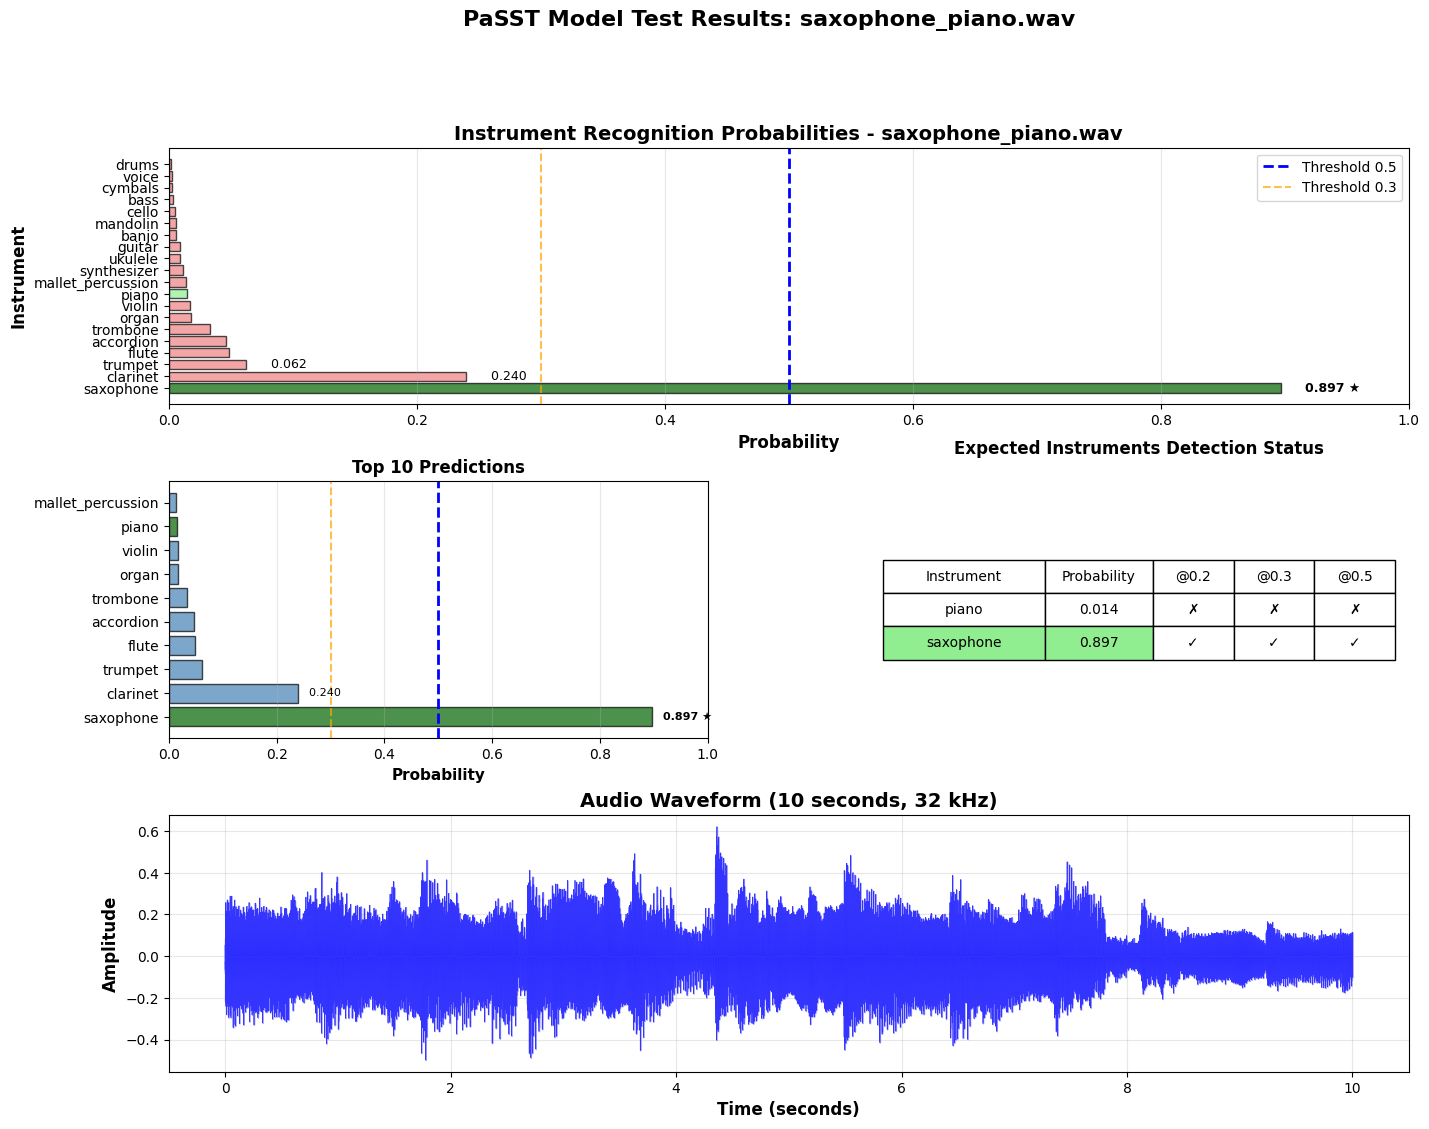


SUMMARY

Top 3 predicted instruments:
  1. saxophone            - 89.66% ★
  2. clarinet             - 23.96% 
  3. trumpet              -  6.23% 

Expected instruments: piano, saxophone

Detection status (at threshold 0.2):
  piano          :  1.44% - ✗ NOT DETECTED
  saxophone      : 89.66% - ✓ DETECTED


In [32]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Probability bar chart (all instruments)
ax1 = fig.add_subplot(gs[0, :])
colors_bar = []
for _, row in results_df.iterrows():
    if row['is_expected']:
        if row['probability'] >= 0.5:
            colors_bar.append('darkgreen')
        elif row['probability'] >= 0.3:
            colors_bar.append('green')
        else:
            colors_bar.append('lightgreen')
    else:
        if row['probability'] >= 0.5:
            colors_bar.append('red')
        elif row['probability'] >= 0.3:
            colors_bar.append('orange')
        else:
            colors_bar.append('lightcoral')

bars = ax1.barh(results_df['instrument'], results_df['probability'],
                 color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1)
ax1.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold 0.5')
ax1.axvline(x=0.3, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold 0.3')
ax1.set_xlabel('Probability', fontsize=12, fontweight='bold')
ax1.set_ylabel('Instrument', fontsize=12, fontweight='bold')
ax1.set_title(f'Instrument Recognition Probabilities - {AUDIO_PATH.name}', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# Add value labels and highlight expected instruments
for i, (bar, (_, row)) in enumerate(zip(bars, results_df.iterrows())):
    prob = row['probability']
    if prob > 0.05:  # Label if probability is significant
        marker = "★" if row['is_expected'] else ""
        ax1.text(prob + 0.02, i, f'{prob:.3f} {marker}',
                va='center', fontsize=9, fontweight='bold' if row['is_expected'] else 'normal')

# Plot 2: Top predictions only (top 10)
ax2 = fig.add_subplot(gs[1, 0])
top_10 = results_df.head(10)
colors_top = ['darkgreen' if row['is_expected'] else 'steelblue' for _, row in top_10.iterrows()]
bars2 = ax2.barh(range(len(top_10)), top_10['probability'], color=colors_top, alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels(top_10['instrument'])
ax2.axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
ax2.axvline(x=0.3, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Probability', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Predictions', fontsize=12, fontweight='bold')
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)
for i, (bar, (_, row)) in enumerate(zip(bars2, top_10.iterrows())):
    if row['probability'] > 0.1:
        marker = "★" if row['is_expected'] else ""
        ax2.text(row['probability'] + 0.02, i, f'{row["probability"]:.3f} {marker}',
                va='center', fontsize=8, fontweight='bold' if row['is_expected'] else 'normal')

# Plot 3: Detection summary table
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')
summary_data = []
for inst in EXPECTED_INSTRUMENTS:
    row = results_df[results_df['instrument'] == inst].iloc[0]
    detected_02 = "✓" if row['detected_0.2'] else "✗"
    detected_03 = "✓" if row['detected_0.3'] else "✗"
    detected_05 = "✓" if row['detected_0.5'] else "✗"
    summary_data.append([inst, f"{row['probability']:.3f}", detected_02, detected_03, detected_05])

table = ax3.table(cellText=summary_data,
                  colLabels=['Instrument', 'Probability', '@0.2', '@0.3', '@0.5'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.2, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(summary_data)):
    if float(summary_data[i][1]) >= 0.3:
        table[(i+1, 0)].set_facecolor('#90EE90')
        table[(i+1, 1)].set_facecolor('#90EE90')
ax3.set_title('Expected Instruments Detection Status', fontsize=12, fontweight='bold', pad=20)

# Plot 4: Waveform visualization
ax4 = fig.add_subplot(gs[2, :])
time_axis = np.arange(len(wav_processed)) / TARGET_SR
ax4.plot(time_axis, wav_processed.numpy(), linewidth=0.5, alpha=0.7, color='blue')
ax4.fill_between(time_axis, wav_processed.numpy(), alpha=0.3, color='blue')
ax4.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Amplitude', fontsize=12, fontweight='bold')
ax4.set_title('Audio Waveform (10 seconds, 32 kHz)', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.suptitle(f'PaSST Model Test Results: {AUDIO_PATH.name}', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
top_3 = results_df.head(3)
print(f"\nTop 3 predicted instruments:")
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    marker = "★" if row['is_expected'] else ""
    print(f"  {i}. {row['instrument']:20s} - {row['probability']*100:5.2f}% {marker}")

print(f"\nExpected instruments: {', '.join(EXPECTED_INSTRUMENTS)}")
print("\nDetection status (at threshold 0.2):")
for inst in EXPECTED_INSTRUMENTS:
    prob = results_df[results_df['instrument'] == inst]['probability'].values[0]
    status = "✓ DETECTED" if prob >= 0.2 else "✗ NOT DETECTED"
    print(f"  {inst:15s}: {prob*100:5.2f}% - {status}")


## 7. Save Results


In [33]:
# Save results to CSV
output_path = Path("/content/drive/MyDrive/deep_learning/passt_real_audio_test_results.csv")
results_df.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

# Create report-ready summary table
print("\n" + "="*80)
print("REPORT-READY SUMMARY TABLE")
print("="*80)
report_table = []
for inst in EXPECTED_INSTRUMENTS:
    row = results_df[results_df['instrument'] == inst].iloc[0]
    report_table.append({
        'Expected Instrument': inst,
        'Probability': f"{row['probability']:.3f}",
        'Detected (0.2)': 'Yes' if row['detected_0.2'] else 'No',
        'Detected (0.3)': 'Yes' if row['detected_0.3'] else 'No',
        'Detected (0.5)': 'Yes' if row['detected_0.5'] else 'No'
    })

report_df = pd.DataFrame(report_table)
print("\nDetection Results Table (for report):")
print(report_df.to_string(index=False))

# Save report table
report_path = Path("/content/drive/MyDrive/deep_learning/passt_real_audio_report_table.csv")
report_df.to_csv(report_path, index=False)
print(f"\nReport table saved to: {report_path}")

# Print final summary
print("\n" + "="*80)
print("TEST COMPLETE")
print("="*80)
print(f"Model: PaSST (trained on OpenMIC + Synthetic)")
print(f"Test audio: {AUDIO_PATH.name}")
print(f"Expected instruments: {', '.join(EXPECTED_INSTRUMENTS)}")
print(f"Total instruments detected (prob >= 0.2): {(results_df['probability'] >= 0.2).sum()}")
print(f"Total instruments detected (prob >= 0.3): {(results_df['probability'] >= 0.3).sum()}")
print(f"Total instruments detected (prob >= 0.5): {(results_df['probability'] >= 0.5).sum()}")
print("="*80)


Results saved to: /content/drive/MyDrive/deep_learning/passt_real_audio_test_results.csv

REPORT-READY SUMMARY TABLE

Detection Results Table (for report):
Expected Instrument Probability Detected (0.2) Detected (0.3) Detected (0.5)
              piano       0.014             No             No             No
          saxophone       0.897            Yes            Yes            Yes

Report table saved to: /content/drive/MyDrive/deep_learning/passt_real_audio_report_table.csv

TEST COMPLETE
Model: PaSST (trained on OpenMIC + Synthetic)
Test audio: saxophone_piano.wav
Expected instruments: piano, saxophone
Total instruments detected (prob >= 0.2): 2
Total instruments detected (prob >= 0.3): 1
Total instruments detected (prob >= 0.5): 1
